In [1]:
import pandas as pd
import numpy as np
from db_conn import DBConnection
import datetime
import psycopg2.extras as extras

In [2]:
db_obj = DBConnection()
expenses = pd.read_sql('select * from expenses;', db_obj.conn, index_col='id');

# Simple Exponential Smoothing (SES)

In [3]:
expenses = pd.read_sql('''select * from expenses;''', db_obj.conn, index_col='id')
expenses.head()

,expense_date,category,amount
id,,,
1,2021-01-01,Shopping,11.11
2,2021-01-02,Mortgage & Rent,1247.44
3,2021-01-02,Food & Dining,24.22
4,2021-01-04,Entertainment,11.76
5,2021-01-05,Food & Dining,25.85


In [4]:
expenses['expense_date'] = pd.to_datetime(expenses['expense_date'], infer_datetime_format=True)
expenses = pd.DataFrame(expenses.resample(rule='M', on='expense_date')['amount'].sum()).reset_index()
expenses.head()

,expense_date,amount
0,2021-01-31,2931.45
1,2021-02-28,3165.05
2,2021-03-31,3500.16
3,2021-04-30,6029.54
4,2021-05-31,3642.03


In [5]:
dates = pd.to_datetime(expenses['expense_date'], infer_datetime_format=True)
dates = dates.dt.to_pydatetime()
dates = [datetime.date(year=date.year, month=date.month, day=date.day) for date in dates]

In [6]:
last_predicted_date = max(dates)
last_predicted_date

datetime.date(2022, 12, 31)

In [7]:
expenses = expenses[["amount"]]
expenses.head()

,amount
0,2931.45
1,3165.05
2,3500.16
3,6029.54
4,3642.03


In [8]:
def last_day_of_month(any_day):
    next_month = any_day.replace(day=28) + datetime.timedelta(days=4)
    return next_month - datetime.timedelta(days=next_month.day)

future_n = 12
future_dates = []
last_m = last_predicted_date.month
last_y = last_predicted_date.year
while future_n:
    m = last_m + 1 if last_m != 12 else 1
    y = last_y if last_m != 12 else last_y + 1
    future_dates.append(last_day_of_month(datetime.date(y, m, 1)))
    last_m = m
    last_y = y
    future_n -= 1
future_n = 12

In [9]:
future_dates

[datetime.date(2023, 1, 31),
 datetime.date(2023, 2, 28),
 datetime.date(2023, 3, 31),
 datetime.date(2023, 4, 30),
 datetime.date(2023, 5, 31),
 datetime.date(2023, 6, 30),
 datetime.date(2023, 7, 31),
 datetime.date(2023, 8, 31),
 datetime.date(2023, 9, 30),
 datetime.date(2023, 10, 31),
 datetime.date(2023, 11, 30),
 datetime.date(2023, 12, 31)]

In [10]:
periods = list(range(len(expenses)))
expenses.index = periods
expenses.head()

,amount
0,2931.45
1,3165.05
2,3500.16
3,6029.54
4,3642.03


<AxesSubplot:title={'center':'Expenses Overtime'}, xlabel='Period', ylabel='Cost (In Dollars $)'>

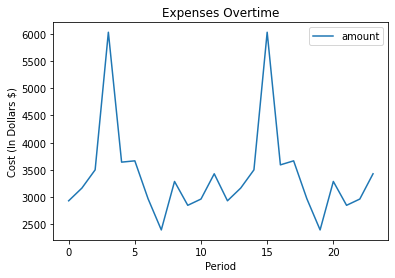

In [11]:
expenses.plot(title='Expenses Overtime', xlabel='Period', ylabel="Cost (In Dollars $)")

In [12]:
from statsmodels.tsa.api import Holt
from statsmodels.tsa.api import ExponentialSmoothing
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [13]:
ses_fit = ExponentialSmoothing(expenses, initialization_method="estimated").fit(
    smoothing_level=0.8, optimized=True
)
ses_forecast = ses_fit.forecast(6).rename(r"$\alpha=0.8$")

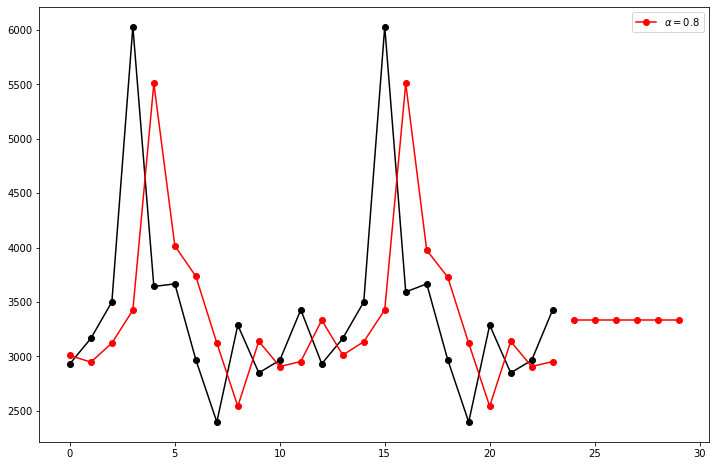

In [14]:
plt.figure(figsize=(12, 8))
plt.plot(expenses, marker="o", color="black")
plt.plot(ses_fit.fittedvalues, marker="o", color="red")
(line3,) = plt.plot(ses_forecast, marker="o", color="red")
plt.legend([line3], [ses_forecast.name])

In [15]:
ses_forecast

24    3332.825684
25    3332.825684
26    3332.825684
27    3332.825684
28    3332.825684
29    3332.825684
Name: $\alpha=0.8$, dtype: float64

In [16]:
hw_add = ExponentialSmoothing(
    expenses,
    seasonal_periods=4,
    trend="add",
    seasonal="add",
    use_boxcox=True,
    initialization_method="estimated",
).fit()
hw_add_fitted_values = list(hw_add.fittedvalues)
hw_add_forecast_values = hw_add.forecast(future_n)

In [17]:
hw_add_forecast_values

24    2904.333968
25    2895.158199
26    2753.395837
27    2926.104239
28    2728.753727
29    2721.070522
30    2601.412707
31    2746.952482
32    2580.431319
33    2573.878582
34    2471.161946
35    2595.931709
dtype: float64

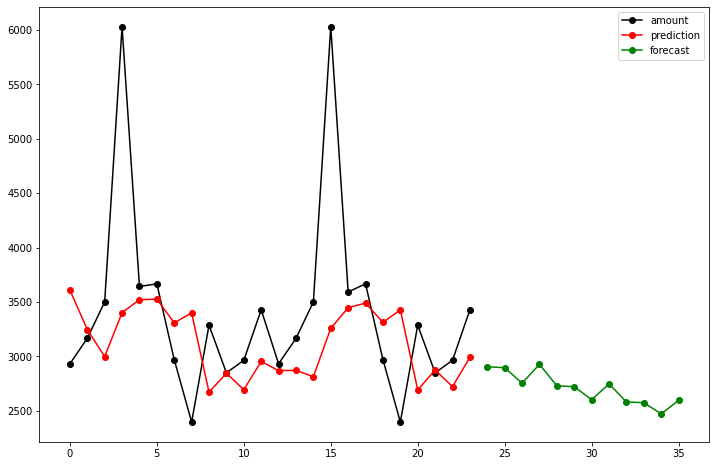

In [18]:
plt.figure(figsize=(12, 8))
plt.plot(periods, list(expenses["amount"]), marker="o", color="black", label="amount")
plt.plot(periods, hw_add_fitted_values, marker="o", color="red", label="prediction", linestyle="-")
plt.plot(hw_add_forecast_values, marker="o", color="green", label="forecast", linestyle="-")
plt.legend()

plt.show()

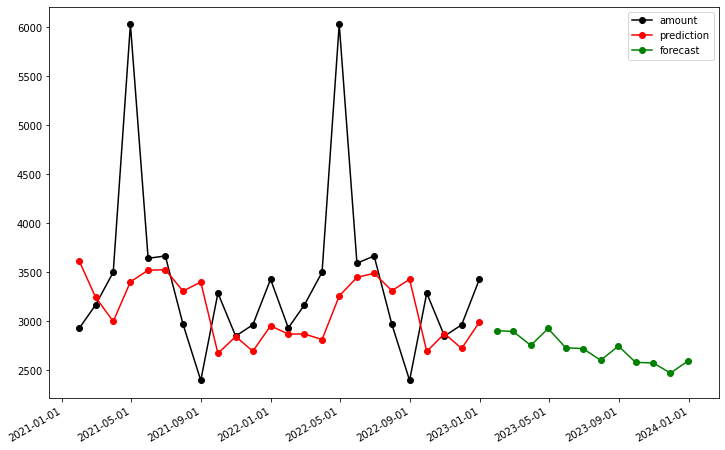

In [19]:
plt.figure(figsize=(12, 8))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.plot(dates, list(expenses["amount"]), marker="o", color="black", label="amount")
plt.plot(dates, hw_add_fitted_values, marker="o", color="red", label="prediction", linestyle="-")
plt.plot(future_dates, list(hw_add_forecast_values), marker="o", color="green", label="forecast", linestyle="-")
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

In [20]:
forecast_df = pd.DataFrame({
    "forecast_date": dates + future_dates,
    "forecast": hw_add_fitted_values + list (hw_add_forecast_values)
})
forecast_df["forecast_date"] = forecast_df["forecast_date"].apply(lambda x: x.strftime("%m/%d/%Y"))
forecast_df["forecast"] = round(forecast_df["forecast"], 1)

In [21]:
forecast_df.tail()

,forecast_date,forecast
31,08/31/2023,2747.0
32,09/30/2023,2580.4
33,10/31/2023,2573.9
34,11/30/2023,2471.2
35,12/31/2023,2595.9


In [22]:
# max_forecast_id = db_obj.execute_statement('select max(id) from forecasts;')
# max_forecast_id = max_forecast_id[0][0] + 1 if max_forecast_id[0][0] != None else 0
# max_forecast_id
# values = ""
# for index, row in forecast_df.iterrows():
#     values += f'''({max_forecast_id + 1}, '{row['forecast_date']}', {round(row['forecast'])}), '''
#     max_forecast_id += 1
# values = values.rstrip(", ")
# values
# db_obj.execute_statement(f'''insert into forecasts(id, forecast_date, forecast) values{values};''', linear=True)
# db_obj.conn.commit()

In [23]:
tuples = [tuple(x) for x in forecast_df.to_numpy()]
tuples = tuple(tuples)
cols = ','.join(list(forecast_df.columns))
query  = "INSERT INTO %s(%s) VALUES %%s" % ("forecasts", cols)
extras.execute_values(db_obj.cur, query, tuples)
db_obj.conn.commit()

In [24]:
forecasted_expenses_query = '''select trim(trailing from 
to_char(forecast_date, 'Mon')) as month, extract(year from forecast_date) as year, 
extract(month from forecast_date) as month_num,
round(SUM(forecast)::decimal, 2) as forecast from forecasts 
where id in (select max(id) from forecasts f2 group by forecast_date) 
group by 1,2,3
order by 2,3'''